# Hybrid Recommender System

## Project Aim:
    - Explore, Create and validate various types of Recommender Systems 
        - Includes Content based methods, Collaborative filtering methods (models and memory based) and Hybrid methods.

The purpose of a recommender system is to suggest relevant items to users. To achieve this task, there exist two major categories of methods : collaborative filtering methods and content based methods. Before digging more into details of particular algorithms, let’s discuss briefly these two main paradigms.

In [1]:
# Products
import warnings
warnings.filterwarnings("ignore")

## for data
import pandas as pd
import numpy as np
import re
from datetime import datetime

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for machine learning
from sklearn import metrics, preprocessing

## for deep learning
from tensorflow.keras import models, layers, utils  #(2.6.0)

import Utils as ut
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD

from scipy.sparse.linalg import svds

Using TensorFlow backend.


In [2]:
pd.read_excel("data_movies.xlsx", sheet_name="users")

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:
df = pd.read_csv('Clean_Item_Data')
df.drop(['Unnamed: 0', 'adult','vote_average','budget','vote_count','imdbId','tmdbId','cast_size', 'crew_size'],inplace = True,axis = 1)
df

,title,overview,genres,runtime,movieId,cast,keywords,director,score
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",16,81.0,1,"['Tom Hanks', 'Tim Allen', 'Don Rickles']","['jealousi', 'toy', 'boy', 'friendship', 'frie...",John Lasseter,7.575833
1,Jumanji,When siblings Judy and Peter discover an encha...,12,104.0,2,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...","['board gam', 'disappear', ""based on children'...",Joe Johnston,6.782738
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,10749,101.0,3,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret']","['fish', 'best friend', 'duringcreditssting', ...",Howard Deutch,6.252781
3,Heat,"Obsessive master thief, Neil McCauley leads a ...",28,170.0,6,"['Al Pacino', 'Robert De Niro', 'Val Kilmer']","['robberi', 'detect', 'bank', 'obsess', 'chase...",Michael Mann,7.391490
4,GoldenEye,James Bond must unmask the mysterious head of ...,12,130.0,10,"['Pierce Brosnan', 'Sean Bean', 'Izabella Scor...","['cuba', 'falsely accus', 'secret ident', 'com...",Martin Campbell,6.485324
...,...,...,...,...,...,...,...,...,...
9597,Carry On Camping,Sid and Bernie keep having their amorous inten...,35,88.0,176025,"['Sid James', 'Charles Hawtrey', 'Joan Sims']","['holiday', 'nudist camp', 'camp', 'tent', 'fi...",Gerald Thomas,6.220681
9598,In a Heartbeat,A closeted boy runs the risk of being outed by...,10751,4.0,176211,[],"['love', 'teenag', 'lgbt', 'short']",Beth David,6.686298
9599,The Man with the Rubber Head,A chemist in his laboratory places upon a tabl...,35,3.0,176223,['Georges Méliès'],"['laboratori', 'mad scientist', 'disembodied h...",Georges Méliès,6.284176
9600,The Devilish Tenant,A man rents an apartment and furnishes it in r...,14,6.0,176229,"['André Méliès', 'Georges Méliès']","['tenant', 'silent film']",Georges Méliès,6.218234


In [4]:
# Avoiding cold start problem by ensuring each user has a movie that they have watched in train and test set.
# Not exactly realistic but this project is only exploring RS not deploying any
rating = pd.read_csv('ratings.csv')
rating = rating[rating.userId.isin(ut.random_sample(rating.userId.unique(),9000))]
rating = rating[rating.userId.map(rating.userId.value_counts())>4]

rating, rating_test = train_test_split(rating,
                                   stratify=rating['userId'], 
                                   test_size=0.20,
                                   random_state=432)

movieId_set = set.intersection(set(rating_test.movieId), 
                               set(rating.movieId), 
                               set(df.movieId))

rating_test = rating_test[rating_test.movieId.isin(movieId_set)]
rating = rating[rating.movieId.isin(movieId_set)]
df = df[df.movieId.isin(movieId_set)]

df = df.reset_index(drop=True)
rating = rating.reset_index(drop=True)

In [5]:
df

,title,overview,genres,runtime,movieId,cast,keywords,director,score
0,Toy Story,"Led by Woody, Andy's toys live happily in his ...",16,81.0,1,"['Tom Hanks', 'Tim Allen', 'Don Rickles']","['jealousi', 'toy', 'boy', 'friendship', 'frie...",John Lasseter,7.575833
1,Jumanji,When siblings Judy and Peter discover an encha...,12,104.0,2,"['Robin Williams', 'Jonathan Hyde', 'Kirsten D...","['board gam', 'disappear', ""based on children'...",Joe Johnston,6.782738
2,Grumpier Old Men,A family wedding reignites the ancient feud be...,10749,101.0,3,"['Walter Matthau', 'Jack Lemmon', 'Ann-Margret']","['fish', 'best friend', 'duringcreditssting', ...",Howard Deutch,6.252781
3,Heat,"Obsessive master thief, Neil McCauley leads a ...",28,170.0,6,"['Al Pacino', 'Robert De Niro', 'Val Kilmer']","['robberi', 'detect', 'bank', 'obsess', 'chase...",Michael Mann,7.391490
4,GoldenEye,James Bond must unmask the mysterious head of ...,12,130.0,10,"['Pierce Brosnan', 'Sean Bean', 'Izabella Scor...","['cuba', 'falsely accus', 'secret ident', 'com...",Martin Campbell,6.485324
...,...,...,...,...,...,...,...,...,...
5228,Mindhorn,"A washed up actor who played Mindhorn, a secre...",35,89.0,171881,"['Julian Barratt', 'Simon Farnaby', 'Essie Dav...","['amateur detect', 'murder', 'aging actor', 'p...",Sean Foley,6.228468
5229,Valerian and the City of a Thousand Planets,"In the 28th century, Valerian and Laureline ar...",12,137.0,173291,"['Dane DeHaan', 'Cara Delevingne', 'Clive Owen']","['shapeshift', 'futur', 'utopia', 'space trave...",Luc Besson,6.526412
5230,Hasan Minhaj: Homecoming King,"Comic Hasan Minhaj of ""The Daily Show"" shares ...",35,72.0,173429,[],"['childhood memori', 'high school', 'stand-up ...",Christopher Storer,6.287664
5231,Black Mirror: White Christmas,This feature-length special consists of three ...,18,74.0,174053,"['Jon Hamm', 'Rafe Spall', 'Oona Chaplin']","['artificial intellig', 'confess', 'technolog'...",Carl Tibbetts,6.835714


In [6]:
rating

,userId,movieId,rating,timestamp
0,170133,34405,4.5,1456416550
1,107745,5618,2.0,1415198665
2,195415,3578,5.0,1446892116
3,144375,26850,3.5,1234967929
4,135962,2571,4.5,1417380771
...,...,...,...,...
510801,220221,2527,4.0,944247012
510802,250362,475,4.0,1337018571
510803,156128,1196,3.0,1452551877
510804,163686,1,4.0,1158521916


In [7]:
rating_test

,userId,movieId,rating,timestamp
18049766,187411,2160,4.0,1241616911
25099842,261169,4720,4.0,1296249722
10290149,106198,923,5.0,976064323
17621724,182803,8972,1.5,1226939578
21875380,227315,1208,4.0,1042654503
...,...,...,...,...
1469013,15099,7022,4.5,1225248793
2416716,25044,1394,5.0,1127930875
2132590,22150,122904,4.0,1500057992
10297506,106293,2297,3.0,963001732


## 1. Naive Model

### For each user recommend the top 5 highest scoring movies that they have not watched

This model has a suprising very good score

In [8]:
# example
user = rating.userId.sample(1).iloc[0]
ut.simple(user,df,rating,5)

,title,overview,genres,runtime,movieId,cast,keywords,director,score
3853,The Dark Knight,Batman raises the stakes in his war on crime. ...,18,152.0,58559,"['Christian Bale', 'Michael Caine', 'Heath Led...","['dc comic', 'crime fight', 'secret ident', 's...",Christopher Nolan,8.219441
124,Pulp Fiction,"A burger-loving hit man, his philosophical par...",53,154.0,296,"['John Travolta', 'Samuel L. Jackson', 'Uma Th...","['transport', 'brothel', 'drug deal', 'boxer',...",Quentin Tarantino,8.187793
4802,Whiplash,"Under the direction of a ruthless instructor, ...",18,105.0,112552,"['Miles Teller', 'J.K. Simmons', 'Melissa Beno...","['jazz', 'obsess', 'conservatori', 'music teac...",Damien Chazelle,8.088796
2162,Spirited Away,A ten year old girl who wanders away from her ...,14,125.0,5618,"['Rumi Hiiragi', 'Miyu Irino', 'Mari Natsuki']","['witch', 'parent child relationship', 'magic'...",Hayao Miyazaki,8.069471
498,The Godfather: Part II,In the continuing saga of the Corleone crime f...,18,200.0,1221,"['Al Pacino', 'Robert Duvall', 'Diane Keaton']","['italo-american', 'cuba', 'vorort', 'melancho...",Francis Ford Coppola,8.037035


In [9]:
rating_test.userId

18049766    187411
25099842    261169
10290149    106198
17621724    182803
21875380    227315
             ...  
1469013      15099
2416716      25044
2132590      22150
10297506    106293
9420105      97260
Name: userId, Length: 128634, dtype: int64

In [10]:
# Testing it
# Useing a very simply method called hit and miss
# for the users in the test set, recommend top n movies, for each movie they have watched (in the test set) its a hit. Then Score = Hits/No. Of Users
sample_size = 200
ut.evaluate(rating_test, 5, 'simple', df, sample_size = sample_size,  rating = rating)

0.285

## 2. Content Based methods

Content-based filtering uses item features to recommend other items similar to what the user likes, based on their previous actions or explicit feedback.

In this case we use a movie that a user has watched and liked previously and utilise information about that movie to find a similar one.

We use a simple approach by combining text of movie overview + keywords + cast + director

If I were wanting to do this more robust I would have a recommender for each bit of text and then commbine them either through there vectors or the outputs of the recommender

In [11]:
df['keywords'] = df['keywords'].apply(ut.clean_text)
df['overview'] = df['overview'].apply(ut.clean_text)
df['cast'] = df['cast'].apply(ut.clean_text)
df['director'] = df['director'].apply(ut.clean_text)

df['overview_clean'] = df['overview']+' '+df['keywords']+' '+df['cast']+' '+df['director']

df['overview_toke'] = df['overview_clean'].apply(ut.clean_text, toke = True)

In [12]:
df.head(3)

,title,overview,genres,runtime,movieId,cast,keywords,director,score,overview_clean,overview_toke
0,Toy Story,led woodi andi toy live happili hi room andi b...,16,81.0,1,tom hank tim allen rickl,jealousi toy boy friendship friend rivalri boy...,john lasset,7.575833,led woodi andi toy live happili hi room andi b...,"[led, woodi, andi, toy, live, happili, hi, roo..."
1,Jumanji,sibl judi peter discov enchant board game open...,12,104.0,2,robin william jonathan hyde kirsten dunst,board gam disappear base children book new hom...,joe johnston,6.782738,sibl judi peter discov enchant board game open...,"[sibl, judi, peter, discov, enchant, board, ga..."
2,Grumpier Old Men,famili wed reignit ancient feud next-door neig...,10749,101.0,3,walter matthau jack lemmon ann-margret,fish best friend duringcreditsst old men,howard deutch,6.252781,famili wed reignit ancient feud next-door neig...,"[famili, wed, reignit, ancient, feud, next-doo..."


### 2.1 TF-IDF

We use SKLEARN TF-IDF vectoriser (its very similar to getting word embeddings from our text, we then utilise cosine similarity to find similar vetors aka movies

The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.



In [13]:
# This computes the vectors and then gets the cosine similarity
tfidf_cosine_sim = ut.TF_IDF(df['overview_clean'], ngram = 5)

In [14]:
ut.top_rec("The Dark Knight",
           tfidf_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df, 5)

4445         The Dark Knight Rises
3366                 Batman Begins
4227    Batman: Under the Red Hood
606                 Batman Returns
Name: title, dtype: object

In [15]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = sample_size, sim = tfidf_cosine_sim)

0.065

## 2.2 Word2Vec

Uses the Word2vec algorithm to get embeddings for our text

In [16]:
word2vec_cosine_sim = ut.Word2Vec_Hybrid(
                                      df['overview_toke'], 
                                      vector_size = 300,
                                      window = 7, 
                                      epochs = 100)

100%|██████████| 26180/26180 [00:21<00:00, 1191.34it/s] 


In [17]:
ut.top_rec("The Dark Knight",
           word2vec_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

4445         The Dark Knight Rises
4227    Batman: Under the Red Hood
3366                 Batman Begins
606                 Batman Returns
Name: title, dtype: object

In [18]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = sample_size, sim = word2vec_cosine_sim)

0.065

## 2.3 Doc2Vec

Uses the Doc2Vec algorithm to get an entire embedding of our text, instead of the more Naive approach of summing word vectors above

In [19]:
doc2vec_cosine_sim = ut.Doc2Word_embed(df['overview_clean'], 
                                    df['overview_toke'], 
                                    vector_size = 300,
                                    window = 15,
                                    epochs = 100)

In [20]:
ut.top_rec("The Dark Knight",
           doc2vec_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

4445         The Dark Knight Rises
4227    Batman: Under the Red Hood
3366                 Batman Begins
241                         Batman
Name: title, dtype: object

In [21]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = sample_size, sim = doc2vec_cosine_sim)

0.045

## 2.4 Simple Hybrid Content based model

We simply combine the cosines of the above models

In [22]:
# assuming the NLP model cosine similarities are comparable we will avg

avg_nlp_sim = (word2vec_cosine_sim+tfidf_cosine_sim)/2


ut.top_rec("The Dark Knight",
           avg_nlp_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

4445         The Dark Knight Rises
3366                 Batman Begins
4227    Batman: Under the Red Hood
606                 Batman Returns
Name: title, dtype: object

In [23]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = sample_size, sim = avg_nlp_sim)

0.045

## 3 Collaborative filtering

To address some of the limitations of content-based filtering, collaborative filtering uses similarities between users and items simultaneously to provide recommendations. This allows for serendipitous recommendations; that is, collaborative filtering models can recommend an item to user A based on the interests of a similar user B. Furthermore, the embeddings can be learned automatically, without relying on hand-engineering of features.

In reality the feeback is usually implicit but for our dataset we have Explicit feeback too, so we opt to use this:

- Explicit: users specify how much they liked a particular movie by providing a numerical rating.
- Implicit: if a user watches a movie, the system infers that the user is interested.


In [24]:
df['index1'] = df.index
new = pd.merge(rating,
               df[["title", 'index1', "movieId"]], 
               how='inner',
               left_on="movieId",
               right_on="movieId")

new = new[["userId","index1","rating"]]
x = pd.pivot_table(new, values='rating', index=['index1'], columns=['userId'], aggfunc=np.max, fill_value=0) 
new.head(2)

,userId,index1,rating
0,170133,3383,4.5
1,202854,3383,2.5


## 3.1 Item based model (Memory based)

This utilises the relation ship between Items that users like

In [25]:
item_cosine_sim = ut.Rating2Vec(x)

In [26]:
ut.top_rec("Terminator 2: Judgment Day",
           item_cosine_sim, 
           pd.Series(df.index, index=df['title']), 
           df,5)

195     Jurassic Park
514    The Terminator
165             Speed
187      The Fugitive
Name: title, dtype: object

In [27]:
ut.evaluate(rating_test, 5, 'CB', df, sample_size = sample_size, sim = item_cosine_sim)

0.22

## 3.2 User Based model (Memory based)

utilises the relationship between users

In [28]:
user_cosine_sim = ut.Rating2Vec(x.T)

In [29]:
indexes = pd.DataFrame(x.T.index)
ut.top_rec_user(rating.userId[0], user_cosine_sim, 10,5,df, x.T,indexes).title

1051                    The Matrix
3366                 Batman Begins
239     Terminator 2: Judgment Day
398                       Die Hard
124                   Pulp Fiction
Name: title, dtype: object

In [30]:
ut.evaluate(rating_test, 5, 'UB', df, sample_size = sample_size, rating = rating, sim = user_cosine_sim, user_matrix = x.T, indexes = indexes, k = 10)

0.19

# 3.3 SVD (Model based)

The factorisation of this matrix is done by the singular value decomposition. It finds factors of matrices from the factorisation of a high-level (user-item-rating) matrix. The singular value decomposition is a method of decomposing a matrix into three other matrices as given below: Where A is a m x n utility matrix, U is a m x r orthogonal left singular matrix, which represents the relationship between users and latent factors, S is a r x r diagonal matrix, which describes the strength of each latent factor and V is a r x n diagonal right singular matrix, which indicates the similarity between items and latent factors. The latent factors here are the characteristics of the items, for example, the genre of the Movie.

In [31]:
M = x.T
U, sigma, Vt = svds(M, k =150)

sigma_diag_matrix = np.diag(sigma)

all_user_predicted_ratings = np.dot(np.dot(U, sigma_diag_matrix), Vt)

preds_df = pd.DataFrame(all_user_predicted_ratings, columns = M.columns, index=M.index)

user_cosine_sim = ut.Rating2Vec(preds_df)

indexes = pd.DataFrame(preds_df.index)

In [32]:
ut.top_rec_user(rating.userId[0], user_cosine_sim, 10,5,df, x.T,indexes).title

1051                    The Matrix
3853               The Dark Knight
398                       Die Hard
239     Terminator 2: Judgment Day
4186      How to Train Your Dragon
Name: title, dtype: object

In [33]:
ut.evaluate(rating_test, 5, 'UB', df, sample_size = sample_size, rating = rating, sim = user_cosine_sim, user_matrix = preds_df, indexes = indexes, k = 10)

0.14

## 3.4 Neural Networks (Model Based)

In [3]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]

# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

# Merge A & B
y_out = layers.Concatenate()([cf_xx, nn_xx])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in], outputs=y_out, name="Neural_CollaborativeFiltering")
model.compile(optimizer='adam', loss='mean_absolute_error',  metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Neural_CollaborativeFiltering"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xusers_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
xproducts_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nn_xusers_emb (Embedding)       (None, 1, 50)        3300        xusers_in[0][0]                  
__________________________________________________________________________________________________
nn_xproducts_emb (Embedding)    (None, 1, 50)        487050      xproducts_in[0][0]               
______________________________________________________________________

2022-06-29 12:49:17.782473: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2299995000 Hz
2022-06-29 12:49:17.783502: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563e6fd3c210 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-29 12:49:17.783526: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-29 12:49:17.783642: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


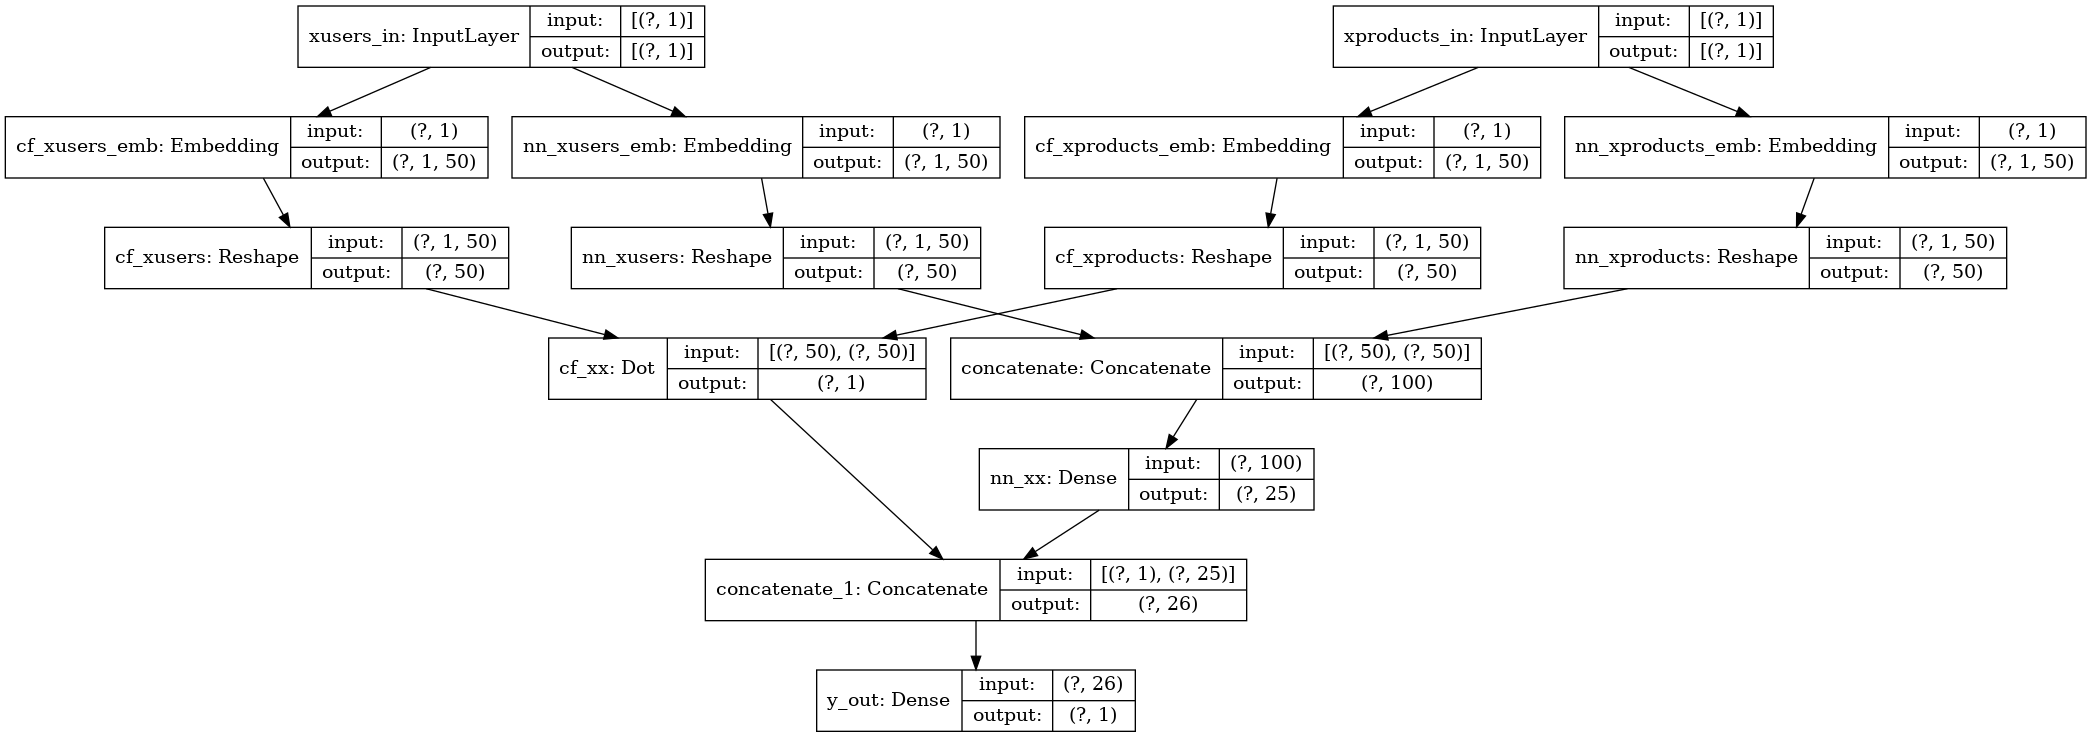

In [4]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/numpy_ops/np_random.py:95: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def randint(low, high=None, size=None, dtype=onp.int):  # pylint: disable=missing-function-docstring


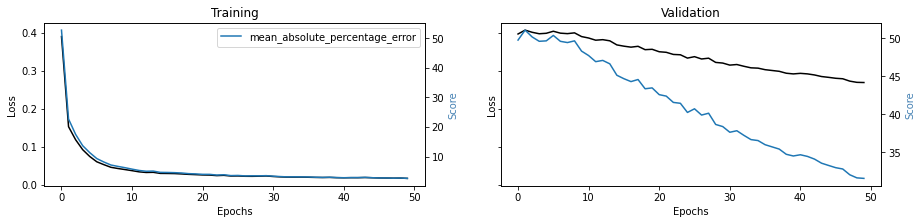

In [5]:
# train
training = model.fit(x=[train["user"], train["product"]], y=train["y"], 
                     epochs=50, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
model = training.model
ut.utils_plot_keras_training(training)

In [6]:
# test
test["yhat"] = model.predict([test["user"], test["product"]])
test

# overall
y_test = test["y"]
predicted = test["yhat"]

In [8]:
ut.NN_Test(test)

0.23529411764705882

# 4. Full Hybrid Neural Network Model

This NN uses the Triplet loss for its loss function

Architecture:
![title](NNArc.jpg)

This NN utilises the rating of movies, movie text, user profile and context such as movie length.


In [13]:
embeddings_size = 50
usr, prd = dtf_users.shape[0], dtf_users.shape[1]
feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xproducts_in = layers.Input(name="xproducts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)
## embeddings and reshape
cf_xproducts_emb = layers.Embedding(name="cf_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
cf_xproducts = layers.Reshape(name='cf_xproducts', target_shape=(embeddings_size,))(cf_xproducts_emb)
## product
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xproducts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)
## embeddings and reshape
nn_xproducts_emb = layers.Embedding(name="nn_xproducts_emb", input_dim=prd, output_dim=embeddings_size)(xproducts_in)
nn_xproducts = layers.Reshape(name='nn_xproducts', target_shape=(embeddings_size,))(nn_xproducts_emb)
## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xproducts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size/2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Product Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## KNOWLEDGE BASED #################################################
# Context
contexts_in = layers.Input(name="contexts_in", shape=(ctx,))
context_x = layers.Dense(name="context_x", units=ctx, activation='relu')(contexts_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x, context_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in,xproducts_in, features_in, contexts_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xusers_in (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
xproducts_in (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
nn_xusers_emb (Embedding)       (None, 1, 50)        3300        xusers_in[0][0]                  
__________________________________________________________________________________________________
nn_xproducts_emb (Embedding)    (None, 1, 50)        487050      xproducts_in[0][0]               
_______________________________________________________________________________________

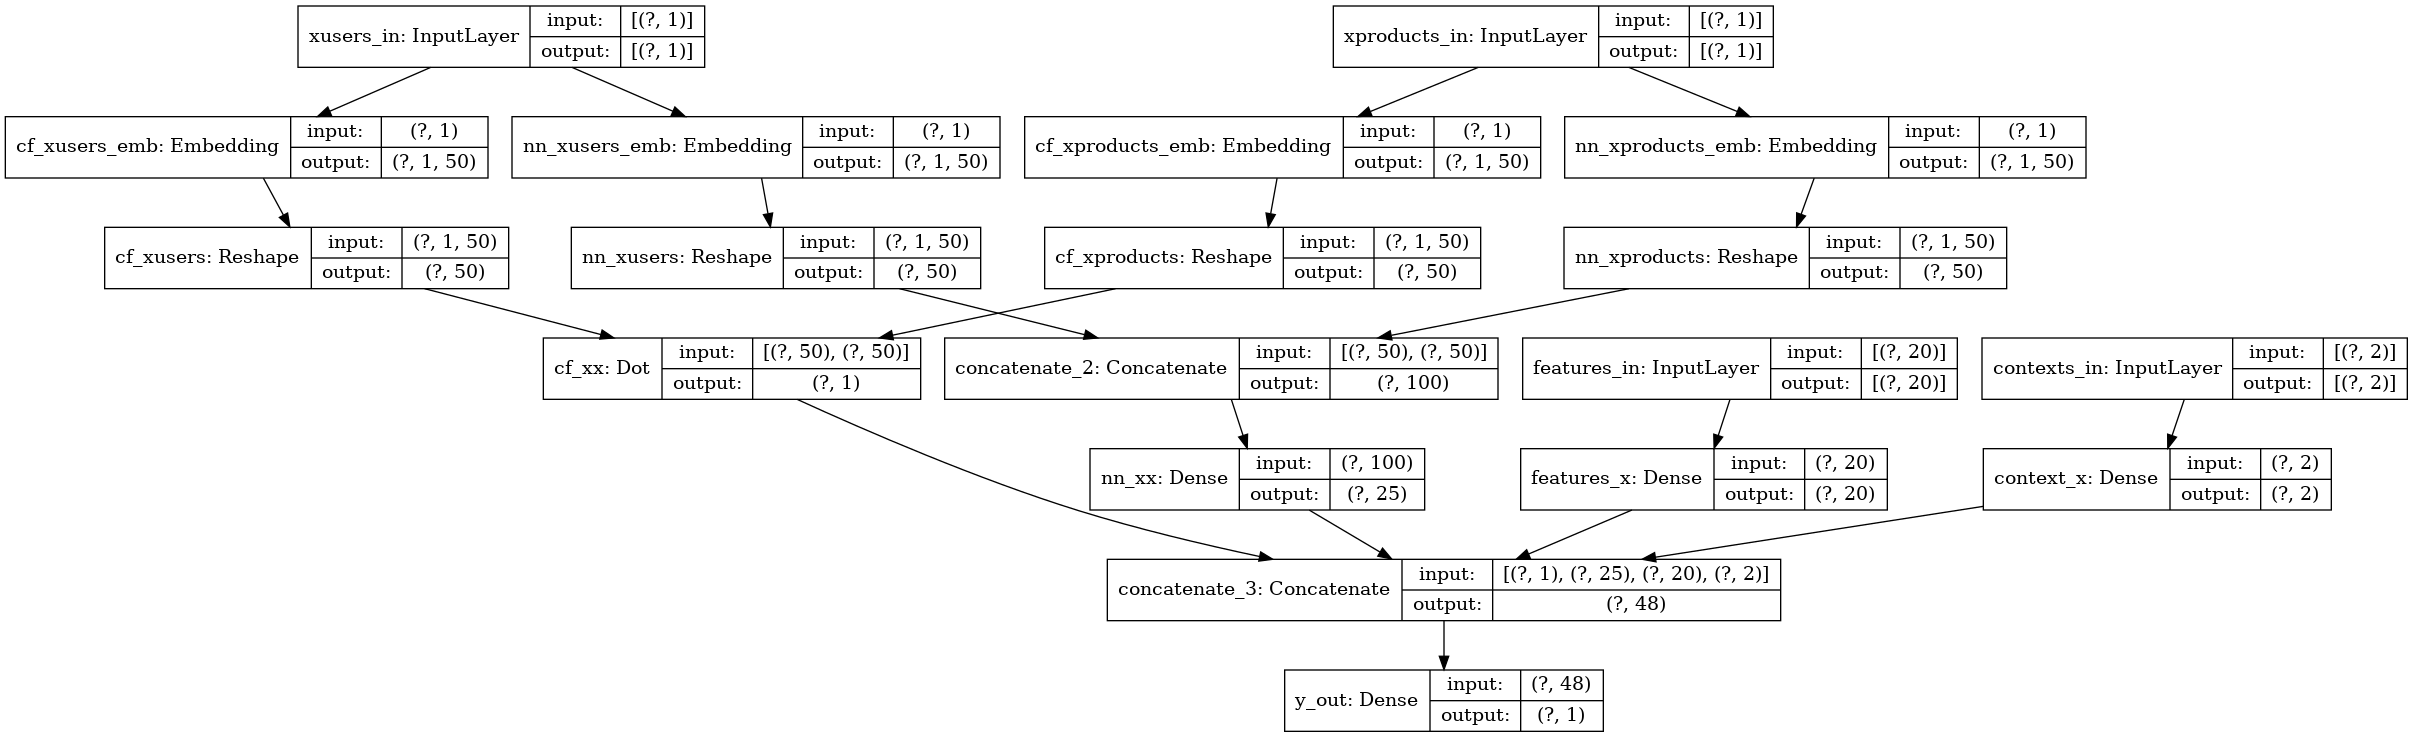

In [14]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [15]:
# train
training = model.fit(x=[train["user"], train["product"], train[features], train[context]], y=train["y"], 
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

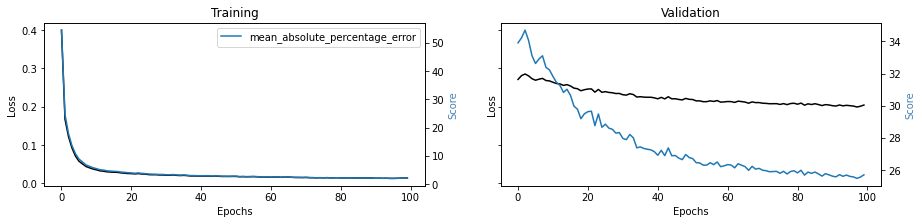

In [17]:
model = training.model
ut.utils_plot_keras_training(training)

In [18]:
# test
test["yhat"] = model.predict([test["user"], test["product"], test[features], test[context]])
test

,user,product,y,old,Sci-Fi,Comedy,Adventure,Thriller,Western,Animation,...,Romance,Action,Children,Fantasy,Crime,Mystery,War,daytime,weekend,yhat
0,1,8063,0.812500,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.646732
1,1,8305,1.000000,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0.771828
2,1,8376,0.777778,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.775388
3,1,8466,0.800000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.621180
4,1,8509,0.500000,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0.690585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,64,8023,0.500000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.529219
667,64,8376,0.944444,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.641343
668,64,8438,0.666667,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0.706842
669,64,8569,0.900000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0.574096


In [20]:
ut.NN_Test(test)

0.29411764705882354

# Conclusion

It is clear that the newer Hybrid models outperform other machine learning models. We saw different use cases based on the data availability: applied a Content-based approach for a single-user scenario, and dived into Collaborative Filtering applications for multiple users-products. More importantly, we understood how to use Neural Networks to improve traditional techniques and build modern hybrid Recommendation Systems that can include context and any other additional information.